In [87]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

%matplotlib inline
# %pdb on

In [11]:
# Load dataset
alzheimer_dataset_path = "Datasets/10_alzheimers_disease_data.csv"
alz_df = pd.read_csv(alzheimer_dataset_path)

#The last column ('DoctorInCharge') contains same and no-relevant data for all patiens. let's remove it:
alz_df = alz_df.drop('DoctorInCharge', axis=1)
alz_df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,6.045039,0,0,0.014691,0,0,1,1,0,0


# Our Goals: #
- Understand to factors that influence the diagnosis
- Predict alzheimer desease

In [3]:
num_of_patients = alz_df.shape[0]
count_alzheimer = alz_df['Diagnosis'].value_counts()[1]
count_no_alzheimer = alz_df['Diagnosis'].value_counts()[0]
diagnosis_data = {
    'Diagnosis': ['Alzheimer', 'No Alzheimer'],
    'Count': [count_alzheimer, count_no_alzheimer]
}
diagnosis_df = pd.DataFrame(diagnosis_data)

First, let's "feel" the data by some infographics.

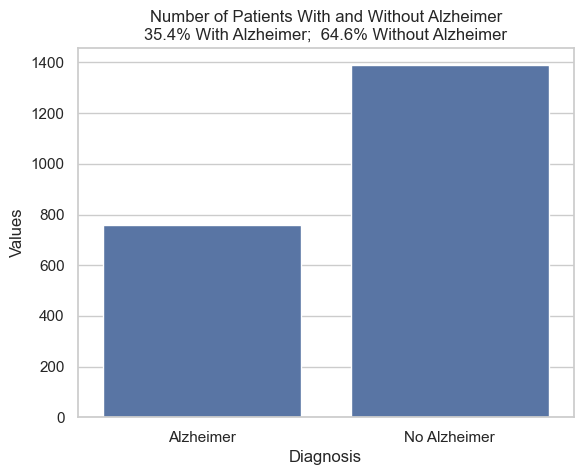

In [4]:
sns.set(style="whitegrid")
sns.barplot(x='Diagnosis', y='Count', data=diagnosis_df)
plt.title('Number of Patients With and Without Alzheimer\n'
          + str(round(100 * count_alzheimer / num_of_patients, 1)) + '% With Alzheimer'  + ';  ' + str(round(100 * count_no_alzheimer / num_of_patients, 1)) + '% Without Alzheimer')
plt.xlabel('Diagnosis')
plt.ylabel('Values')
plt.show()

**Explain**: In the dataset there are details of 1389 healthy patients, and only 760 diagnosed patients. The data in NOT close to be balanced, so we have to take it into account in case of training models.

For some binary features, let's try to figure out how they incluence about the diagnosis.<br>
We use the conditional probabilty formula: $ P(A|B) = P(A\cap B) / P(B) $.

In [5]:
def PlotCondProbSubplot(col_name, subplot_axes, feature_name, zero_feature_name, one_feature_name):
    count_zeros = alz_df[col_name].value_counts()[0]
    count_ones = alz_df[col_name].value_counts()[1]
    count_alz_zeros = ((alz_df[col_name] == 0) & (alz_df['Diagnosis'] == 1)).sum()
    count_alz_ones = ((alz_df[col_name] == 1) & (alz_df['Diagnosis'] == 1)).sum()

    subplot_data = {
        feature_name: [zero_feature_name, one_feature_name],
        'Prob': [count_alz_zeros / count_zeros, count_alz_ones / count_ones]
    }
    subplot_df = pd.DataFrame(subplot_data)

    sns.barplot(x=feature_name, y='Prob', data=subplot_df, ax=subplot_axes, width=0.4)
    subplot_axes.set_ylabel('Probability')
    subplot_axes.set_ylim([0, 1])

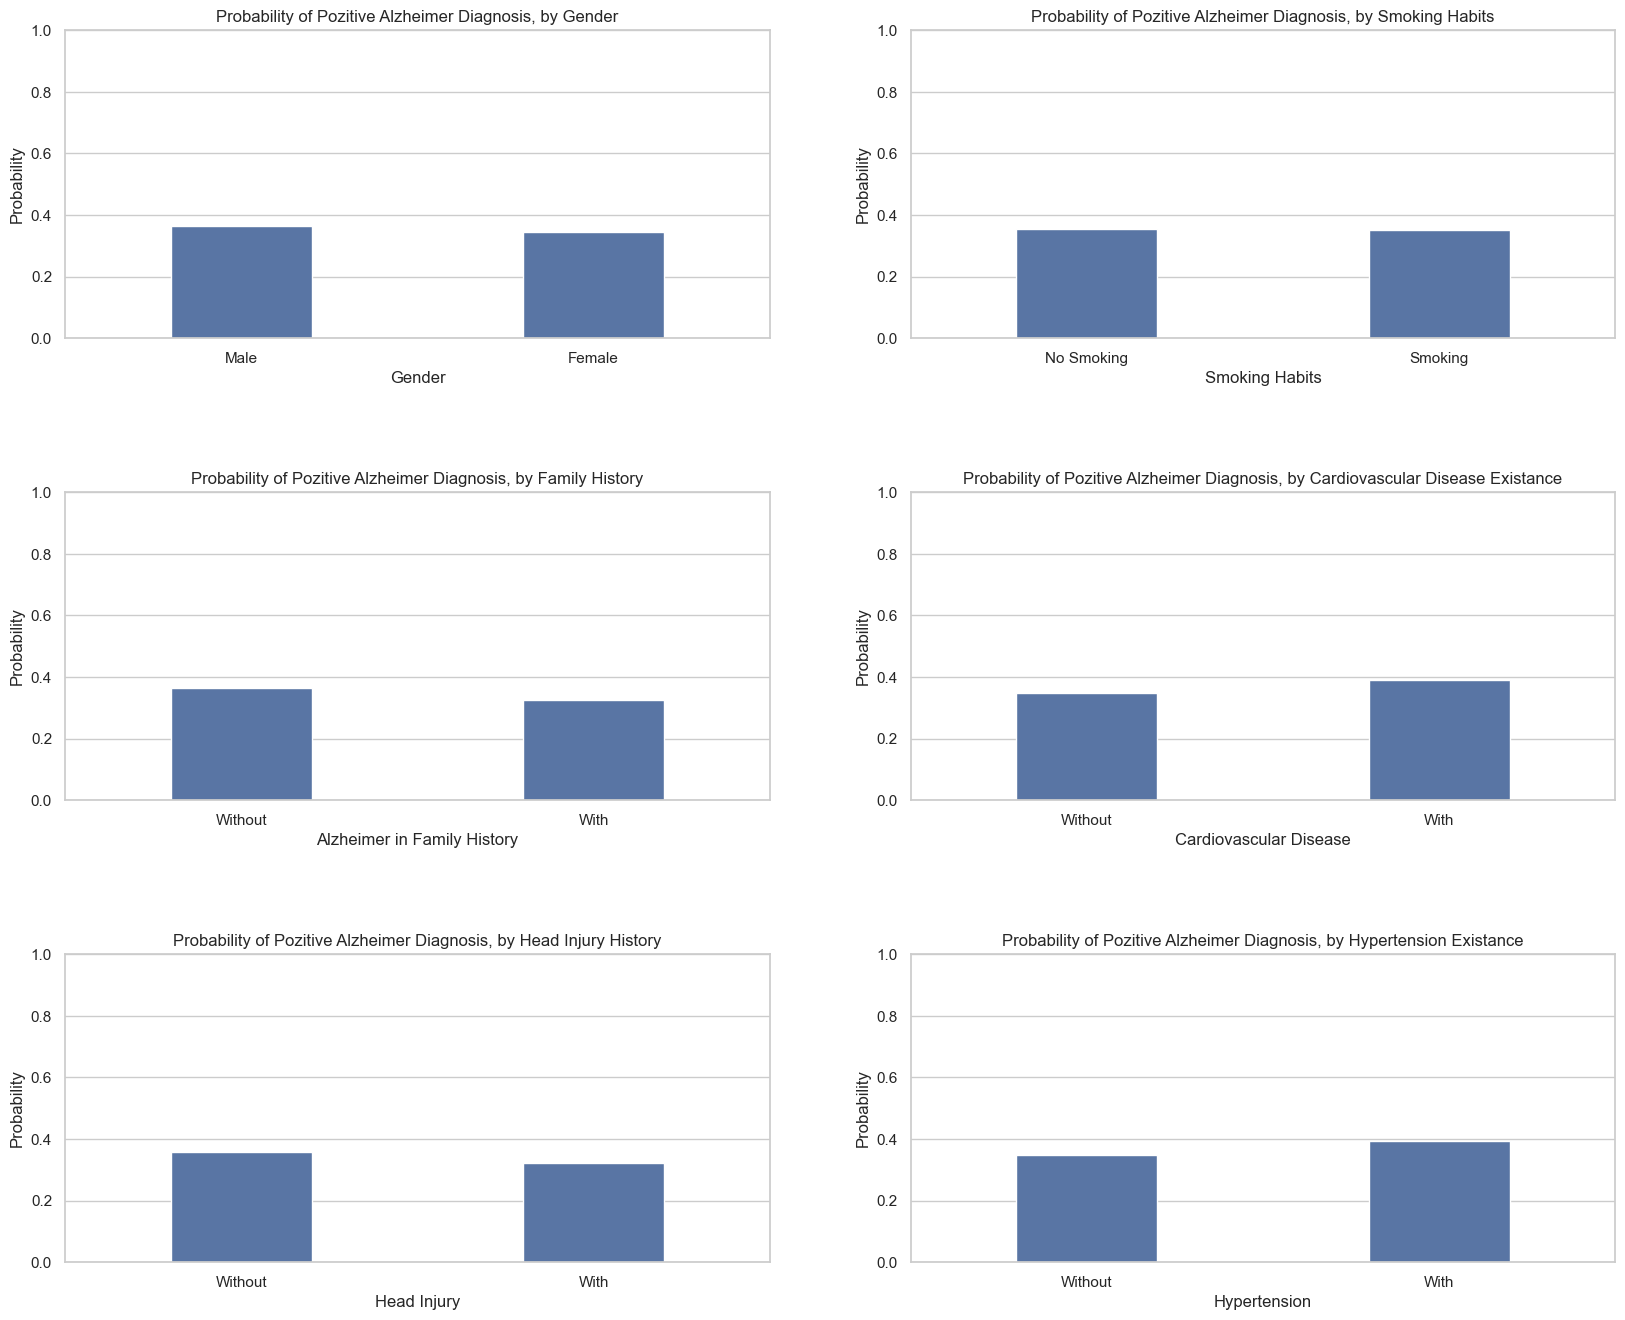

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.2)

PlotCondProbSubplot('Gender', axes[0, 0], 'Gender', 'Male', 'Female')
axes[0, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Gender');

PlotCondProbSubplot('Smoking', axes[0, 1], 'Smoking Habits', 'No Smoking', 'Smoking')
axes[0, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Smoking Habits');

PlotCondProbSubplot('FamilyHistoryAlzheimers', axes[1, 0], 'Alzheimer in Family History', 'Without', 'With')
axes[1, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Family History');

PlotCondProbSubplot('CardiovascularDisease', axes[1, 1], 'Cardiovascular Disease', 'Without', 'With')
axes[1, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Cardiovascular Disease Existance');

PlotCondProbSubplot('HeadInjury', axes[2, 0], 'Head Injury', 'Without', 'With')
axes[2, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Head Injury History');

PlotCondProbSubplot('Hypertension', axes[2, 1], 'Hypertension', 'Without', 'With')
axes[2, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Hypertension Existance');

**Explain:** It appears that no single binary characteristic definitively distinguishes Alzheimer’s patients.

In order to get a wide point of view about the relation between each feature and the diagnosis, let's calculate and look at the correlation matrix.<br>
While the covariance matrix measures the the direction of the joint linear relationship of two variables, The correlation matrix normalizes the covariance to provide both strength and direction of the relationship.<br>

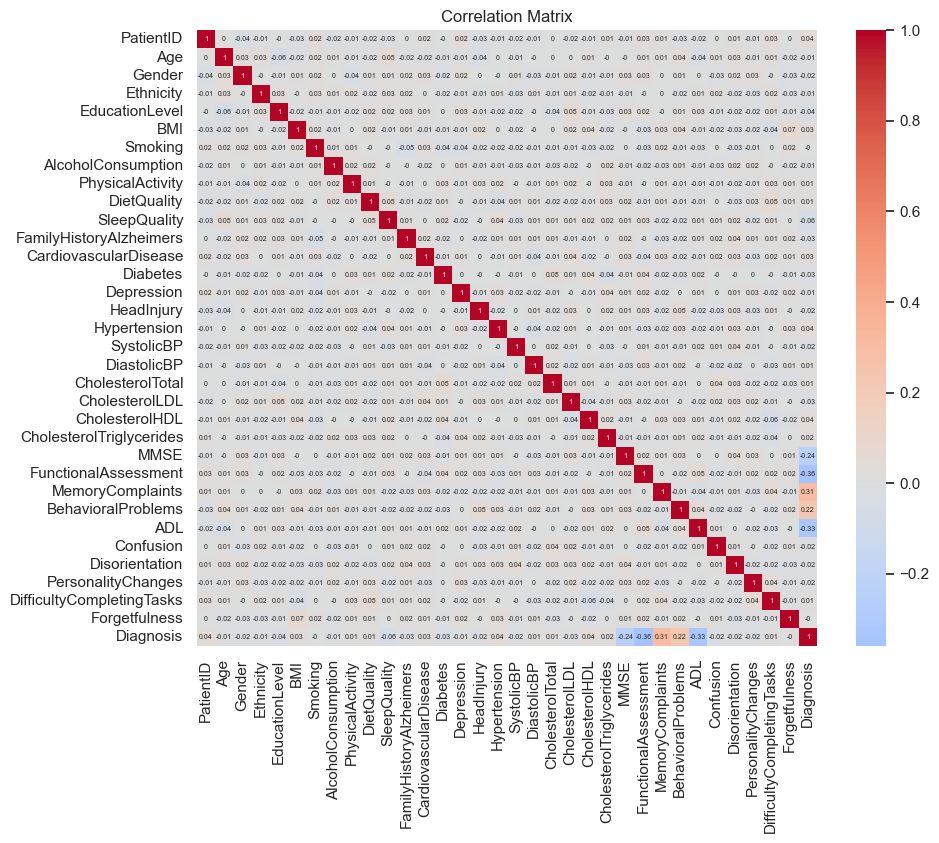

In [7]:
# Calculate correlation matrix
correlation_matrix = alz_df.corr()
correlation_matrix = round(correlation_matrix, 2)

# Get correlation with the label
diagnosis_correlation = correlation_matrix['Diagnosis'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 5})
plt.title('Correlation Matrix')
plt.show()

**Explain:** The last row (or column) in the matrix is the most that matters (represents the correlation between each feature and the 'Diagnosis' label). What we can see is that there are strong correlations between the following features and the diagnosis:
- MMSE (Mini-Mental State Examination)
- functional assessment
- memory complaints
- behavioral probles
- ADL (Activities of Daily Living score)

These results are neither surprising nor useful, as they highlight symptoms of Alzheimer’s rather than identifying characteristics that could cause it (like BMI, cholesterol values, etc.).

## Predictive Model and a Combination of Several Features for Prediction
We will remove the consequential features from the DataFrame and build a predictive model to gain a clearer understanding of the relationships between the disease and its causes.<br>

Before building and training the model, let’s check for any outliers that need to be removed from our data.<br>
Assuming the continuous features follow a normal distribution, we will calculate the Z-score to identify any outliers.

In [115]:
# Preprocess the data
continuous_columns = ['BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']
binary_columns = ['binary_col1', 'binary_col2']

scaler = StandardScaler()
alz_df[continuous_columns] = scaler.fit_transform(alz_df[continuous_columns])

# Initialize and train the One-Class SVM model
model = OneClassSVM(kernel='rbf', nu=0.05)
model.fit(alz_df)

# Predict outliers
predictions = model.predict(alz_df)

# Filter out the outliers
alz_df['outlier'] = predictions
alz_df_inliers = alz_df[alz_df['outlier'] == 1]
alz_df_outliers = alz_df[alz_df['outlier'] == -1]

print("Rate of Inliers:")
print(str(len(alz_df_inliers)) + '/' + str(len(alz_df)))

alz_df = alz_df_inliers

Num of Inliers:
2042/2149


In [116]:
features_df = alz_df
features_df = features_df.drop(
    columns=['PatientID', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'],
    axis=1)
labels = alz_df['Diagnosis']

                     Feature  Importance
9               SleepQuality    0.080539
4                        BMI    0.078241
6         AlcoholConsumption    0.078014
8                DietQuality    0.077105
21  CholesterolTriglycerides    0.076051
20            CholesterolHDL    0.075755
18          CholesterolTotal    0.075112
19            CholesterolLDL    0.072951
7           PhysicalActivity    0.072655
16                SystolicBP    0.067184
17               DiastolicBP    0.065034
0                        Age    0.059911
3             EducationLevel    0.024237
2                  Ethnicity    0.019837
1                     Gender    0.012456
5                    Smoking    0.010642
10   FamilyHistoryAlzheimers    0.010030
13                Depression    0.009585
15              Hypertension    0.009302
12                  Diabetes    0.009129
11     CardiovascularDisease    0.008503
14                HeadInjury    0.007729
22                   outlier    0.000000


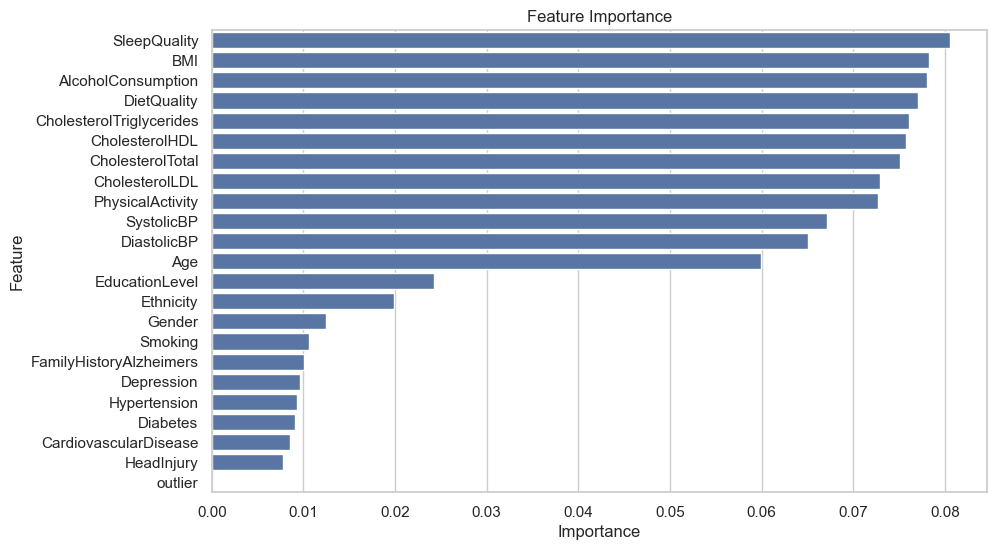

In [117]:
#Split the data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Initialize the model
# We must use balancing option because of the class size differences.
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model
rf_model.fit(X_train, y_train);

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

**Explain:** Although cholesterol triglycerides remain the most significant feature in the model, we still cannot identify it (or any other feature) as a definitive predictor of the diagnosis with relative success.

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       271
           1       0.46      0.04      0.08       138

    accuracy                           0.66       409
   macro avg       0.56      0.51      0.44       409
weighted avg       0.60      0.66      0.55       409



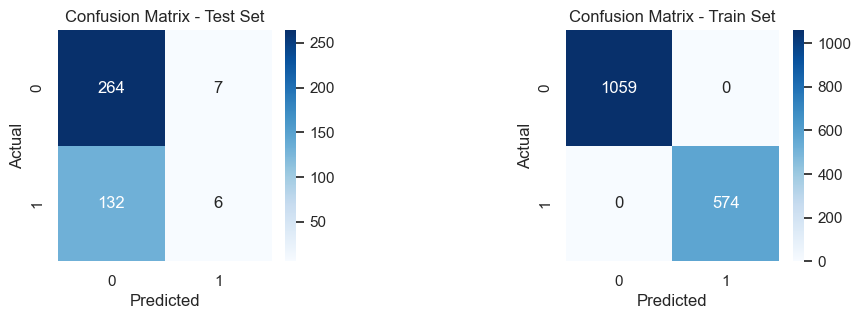

In [118]:
# Predictions
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, and F1-Score
print(classification_report(y_test, y_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.9)

conf_matrix_test = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Test Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

y_pred_train = rf_model.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Train Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

**Explain:** We see clearly that the model prefers to predicts 0 (no Alzheimer), and it causes *type 2* error (false negative).<br>
Models often produce many false alarms when there is an imbalance in the amount of information across different classes. Since we previously adjusted the model to balance the sample sizes from each class, we will now explore a different approach.

Given that the model achieves 100% accuracy on the training set, it appears to be **overfitting**. To improve its generalization, regularization needs to be applied.